In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools

# Part 1

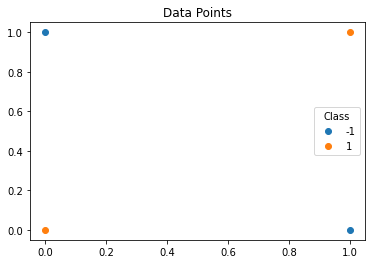

In [2]:
# a) Visualization


samples = pd.DataFrame({
    'x': [1, 0, 1, 0],
    'y': [1, 0, 0, 1],
    'label': [1, 1, -1, -1]
})
for name, group in samples.groupby('label'):
    plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

plt.title('Data Points')
plt.legend(title='Class')



## b) Network implementation

I chose a two layer fully connected network with no hidden layers. I believe this is the simplest model that can still learn XOR. 

I am using relu as my activation function, and binary cross entropy loss. I chose Relu because its derivative is very simple, and BCE because this loss function is developed for classification.


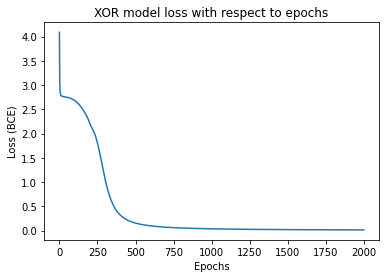

In [3]:
# activation functions
def relu(x):
    return max(0, x)
def d_relu(x):
    return max(0, min(x, 1))    
def sig(x):
    return 1 / (1 + math.e ** -x)
def d_sig(x):
    return sig(x) * (1 - sig(x))
def loss(exp_y, act_y):
    l = 0
    for e, a in zip(exp_y, act_y):
        try:
            if a == 0:
                l -= math.log(1 - e)
            else:
                l -= math.log(e)
        except ValueError:
            l += 9999
    return l


# model
class Neuron:

    def __init__(self, activation_fn=relu):
        np.random.seed(46) # So results are replicable
        self.weights = np.random.rand(3)        
        self.activation_fn = activation_fn

    def pred(self, x, output_pre=False):
        pre_activation = self.weights @ self.concat(x)
        if output_pre:
            return pre_activation
        return self.activation_fn(pre_activation)
    
    def update(self, partials, lr):
        # print(partials)
        self.weights = self.weights - partials * lr
    
    @staticmethod
    def concat(x):
        return np.concatenate((x, [1]))


class NumpyModel:    
    def  __init__(self, lr=.1):
        self.input_layer = [Neuron(), Neuron()]
        self.output_layer = Neuron(activation_fn=sig)
        self.lr = lr
    
    def pred(self, x, output_pre=False):
        return self.output_layer.pred([self.input_layer[0].pred(x), self.input_layer[1].pred(x)], output_pre=output_pre)
    
    def update(self, exp_y, act_y, x):
        # Update output neuron         
        il = self.input_layer
        partial_l_partial_z = -1 / ( exp_y - 1 ) if act_y == 0 else -1 / ( exp_y )
        partial_out = d_sig(self.pred(x, output_pre=True)) * np.array([il[0].pred(x), il[1].pred(x), 1])        
        partial_l_output_layer = partial_l_partial_z * partial_out

        # Update input neuron 
        def update_input_layer(index, neuron):                      
            pre = il[index].pred(x, output_pre=True)
            partial_out = d_sig(self.pred(x, output_pre=True)) * self.output_layer.weights[index] * d_relu(pre) * Neuron.concat(x)
#             print(partial_out)
            out = partial_l_partial_z * partial_out
            neuron.update(out, self.lr)

        update_input_layer(0, self.input_layer[0])
        update_input_layer(1, self.input_layer[1])      

        self.output_layer.update(partial_l_output_layer, self.lr)


  


# Train with stochastic gradient descent
def sgd(model, train_x, train_y):    
    y_preds = []


    for x, y in zip(train_x, train_y):        
        prediction = model.pred(x)      
        y_preds.append(prediction)
        
    # do the updates    
    for i in range(len(train_x)):
        model.update(y_preds[i], train_y[i], train_x[i])
            

def test(model, test_x, test_y, verbose=False):
    exp_y = [model.pred(x) for x in test_x]  
    if verbose:
        print('TEST X:', test_x)       
        print('TEST Y:', test_y)        
        print('PREDICTED Y:', exp_y)        
    return np.mean(loss(exp_y, test_y))


def train(model, train_x, train_y, epochs=10):
    history = []    
    for epoch in range(epochs):
        loss = test(model, train_x, train_y)
        history.append(loss)
        sgd(model, train_x, train_y)
    return history



train_x = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

train_y = np.array([1, 0, 0, 1]) # remap -1 class to 0 so domain of BCE is respected 
m = NumpyModel(.1)
history = train(m, train_x, train_y, epochs=2000)


plt.xlabel('Epochs')
plt.ylabel('Loss (BCE)')

plt.title('XOR model loss with respect to epochs')
plt.plot(history)

TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.9916951754710003, 0.0015616193471831652, 0.0015698167948729775, 0.9989734125501256]
LOSS: 0.012500506655179712


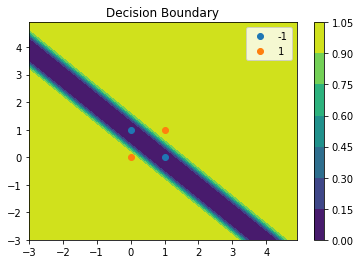

In [4]:
# c) Classification visualization 
# https://towardsdatascience.com/hands-on-guide-to-plotting-a-decision-surface-for-ml-in-python-149710ee2a0e

def model_visualize(m, train_x):   
    print('LOSS:', test(m, train_x, train_y, verbose=True))
    x1_scale = np.arange(-3, 5, 0.1)
    x2_scale = np.arange(-3, 5, 0.1)
    x_grid, y_grid = np.meshgrid(x1_scale, x2_scale)
    x_g, y_g = x_grid.flatten(), y_grid.flatten()
    x_g, y_g = x_g.reshape((len(x_g), 1)), y_g.reshape((len(y_g), 1))
    grid = np.hstack((x_g, y_g))

    preds = []
    for val in grid:
        preds.append(m.pred(val))
    preds = np.array(preds).reshape(80, 80)

    surface = plt.contourf(x_grid, y_grid, preds)

    plt.colorbar(surface)

    samples = pd.DataFrame({
        'x': train_x[:, 0],
        'y': train_x[:, 1],
        'label': [1, -1, -1, 1]
    })    
    for name, group in samples.groupby('label'):
        plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

    plt.title('Decision Boundary')
    plt.legend()
    

model_visualize(m, train_x)

TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.0012109562640487013, 1.0, 0.0004924462055428116, 0.9999906659143697]
LOSS: 10005.716846832256


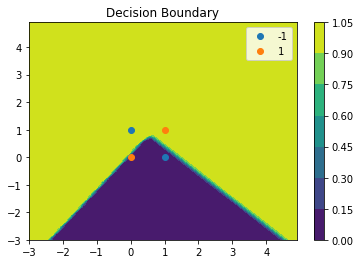

In [5]:
# d) Using random points

def train_and_visualize(sigma, show_train=False):
    np.random.seed(46) # So results are replicable
    train_data = train_x + np.random.normal(loc=0.0, scale=sigma, size=train_x.shape)    
    m = NumpyModel(.1)
    train(m, train_data, train_y, epochs=2000)        
    model_visualize(m, train_x) if not show_train else model_visualize(m, train_data)


train_and_visualize(.5) # This is the loss and graph on the original test data

TEST X: [[ 0.29243792  0.61559787]
 [ 0.41095013  0.60038582]
 [ 1.20602662 -0.08807831]
 [ 0.96341402  0.71716681]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.9791624084654713, 0.03270352420297676, 0.0035336258116267934, 0.995655052896989]
LOSS: 0.06220229278014848


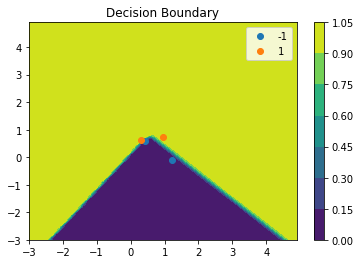

In [6]:
train_and_visualize(.5, show_train=True) # This is the loss on the training data

TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.00039945488601694676, 0.9999999999105447, 0.00039945488601694676, 0.9999999999997888]
LOSS: 30.963090958626058


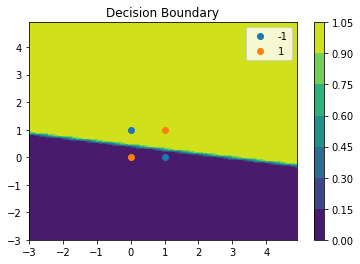

In [7]:
train_and_visualize(1)

TEST X: [[ 0.58487584  1.23119574]
 [ 0.82190026  0.20077164]
 [ 1.41205323 -0.17615661]
 [ 0.92682803  0.43433361]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.9999999999999998, 0.009695692324266224, 0.00039945488601694676, 0.9962216762202477]
LOSS: 0.013928015959838141


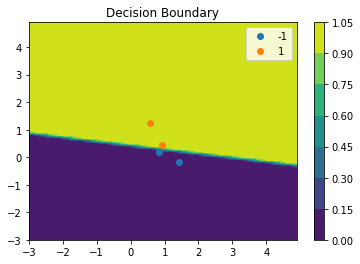

In [8]:
train_and_visualize(1, show_train=True)

TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.9999999390162845, 0.9999999999996461, 0.9989933965121676, 0.9999999941531534]
LOSS: 35.5708250952619


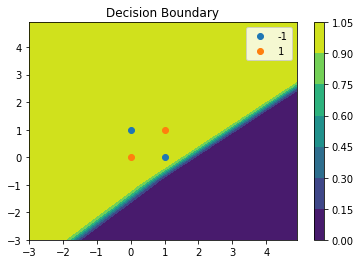

In [9]:
train_and_visualize(2)

TEST X: [[ 1.16975168  2.46239148]
 [ 1.64380053 -0.59845671]
 [ 1.82410646 -0.35231323]
 [ 0.85365606 -0.13133278]]
TEST Y: [1 0 0 1]
PREDICTED Y: [0.9999999999999993, 0.0019095727623040528, 0.004716918677119324, 0.9988164180676541]
LOSS: 0.007823759684375653


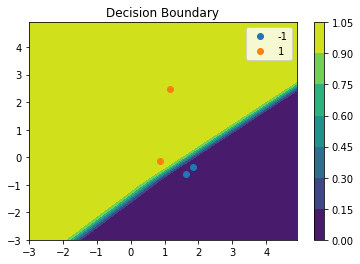

In [10]:
train_and_visualize(2, show_train=True)

## Comments on random training data results

Obviously the model did a lot worse when given the training data with gaussian noise, but I thought it was interesting that when sigma was equal .5 the loss exploded. I would think that in general the loss would increase as sigma increases. Something interesting is that when the model is plotted against the training data, we see that it actually does a decent job finding a good decision boundary. I think if we wanted to see a smaller disparity between train and test loss we would need to give more training data.

# Part 2

In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

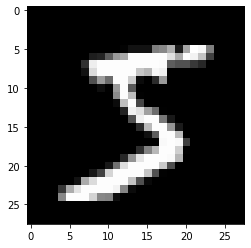

In [12]:
img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img, cmap='gray')

In [13]:
batch_size = 100
n_iters = 3000
# One iteration occurs after accumulating 100 (batch_size) gradients
# One epoch occurs after going through entire training set

num_epochs = n_iters / (len(train_dataset) / batch_size) # The number of iterations divided by amount of iterations in one epoch
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)                                    

In [14]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [15]:
input_dim = 28*28
output_dim = 10


model = LogisticRegressionModel(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  


In [16]:
def calc_accuracy(train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images to a Torch Variable
        images = images.view(-1, 28*28).requires_grad_()

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(lr): # make into train function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  
    accuracy = {'train': [], 'test': []} # keep track of accuracies

    for epoch in range(num_epochs):    
        for i, (images, labels) in enumerate(train_loader): # One epoch = 600 iterations or (train_dataset / batch_size)
            # This will load batch_size amount of samples

            # Load images as Variable
            images = images.view(-1, 28*28).requires_grad_()
            labels = labels
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy() # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item()) # add to accuracy return
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)


Training with learning rate 1e-05
Epoch: 0 Loss: 2.3527894020080566. Train Accuracy: 10.866666793823242, Test Accuracy: 11.479999542236328
Epoch: 1 Loss: 2.310742139816284. Train Accuracy: 11.34666633605957, Test Accuracy: 11.960000038146973
Epoch: 2 Loss: 2.315594434738159. Train Accuracy: 11.859999656677246, Test Accuracy: 12.430000305175781
Epoch: 3 Loss: 2.3233141899108887. Train Accuracy: 12.40999984741211, Test Accuracy: 13.100000381469727
Epoch: 4 Loss: 2.314781904220581. Train Accuracy: 12.984999656677246, Test Accuracy: 13.819999694824219
Training with learning rate 0.0001
Epoch: 0 Loss: 2.2550854682922363. Train Accuracy: 16.888334274291992, Test Accuracy: 14.779999732971191
Epoch: 1 Loss: 2.2409136295318604. Train Accuracy: 26.081666946411133, Test Accuracy: 24.299999237060547
Epoch: 2 Loss: 2.1684470176696777. Train Accuracy: 35.04666519165039, Test Accuracy: 33.400001525878906
Epoch: 3 Loss: 2.1192543506622314. Train Accuracy: 43.17333221435547, Test Accuracy: 42.259998321

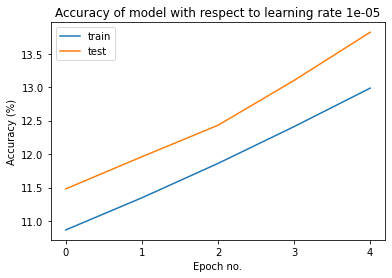

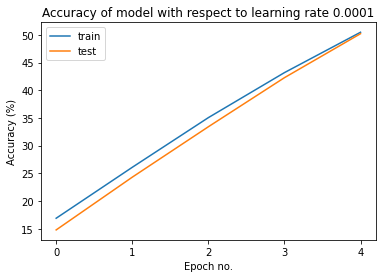

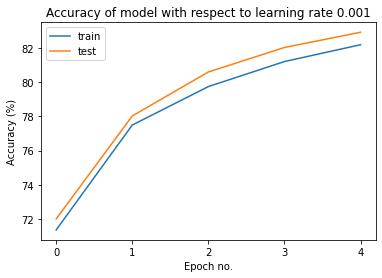

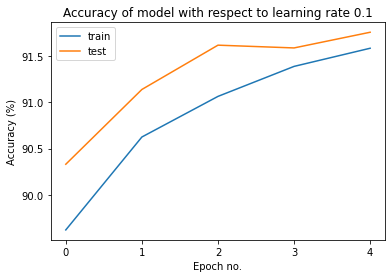

In [17]:
# a) Calculate training and test accuracy at the end of each epoch and the following learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.1]
for lr in learning_rates:
    model.linear.reset_parameters()
    print(f'Training with learning rate {lr}')
    history = train(lr)
    
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.title(f'Accuracy of model with respect to learning rate {lr}')
    plt.gca().set_xticks(list(range(0, num_epochs)))

## Observations on training and test accuracy with respect to learning rate

It seems like accuracy increased as learning rate increased, which makes sense because the model was able to make more meaningful shifts with a higher learning rate. However, I'm sure that if we kept increasing the learning rate we would eventually hit a point where the accuracy jumps all over the place. It was also very surprising to me that the test accuracy was consistently higher than the train accuracy: I would've expected the opposite.

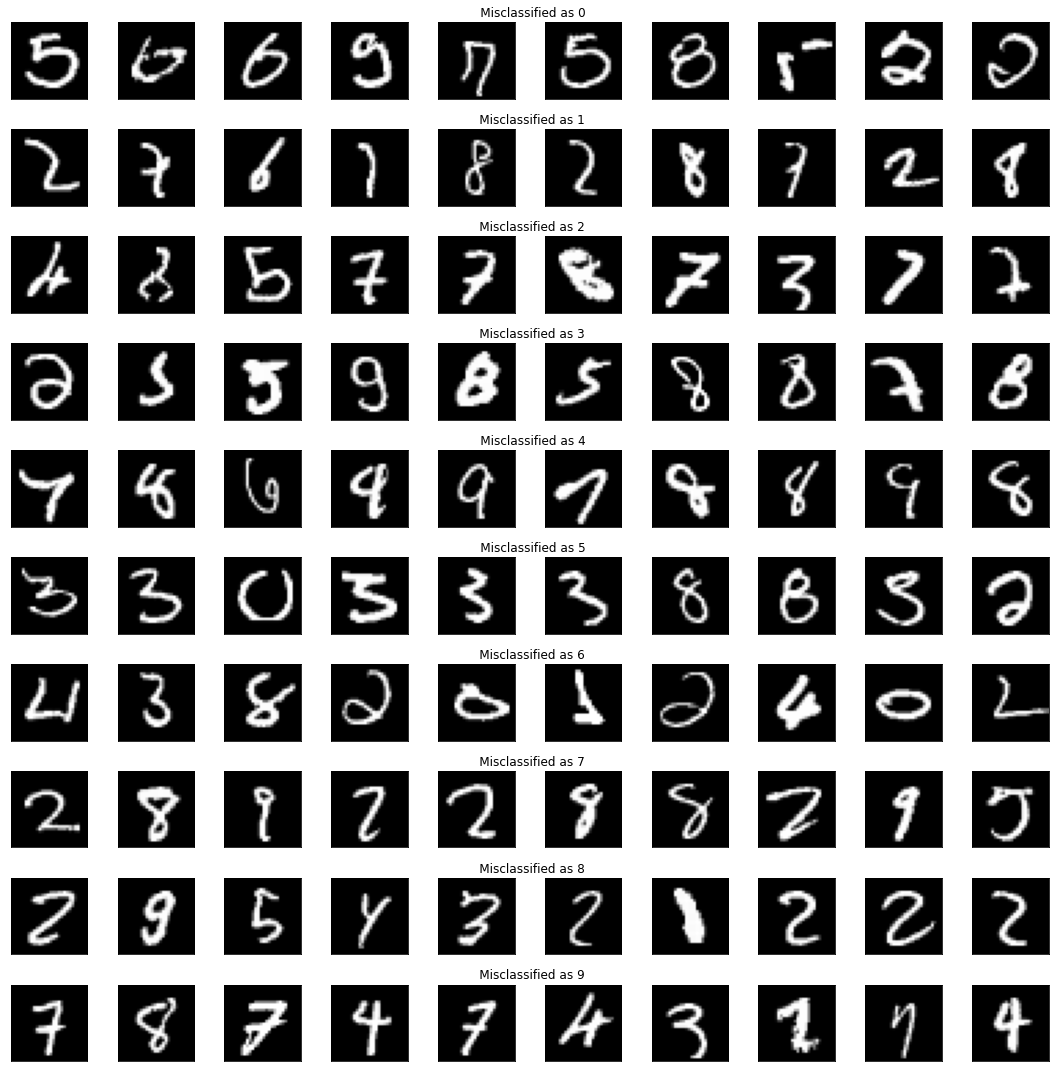

In [18]:
# b) Find 10 misclassified test samples for each output class

misclassified = {k: [] for k in range(10)}
incorrect = []
i = 0
for images, labels in test_loader:
    images = images.view(-1, 28*28)

    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)    
    for pred, act, image in zip(predicted, labels, images):
        if pred != act:
            misclassified[pred.item()].append(image) # save misclassified images





fig=plt.figure(figsize=(15, 15))

for clas in range(10):
    for i in range(1, 11):
        img = misclassified[clas][i].numpy().reshape(28, 28)
        ax = fig.add_subplot(10, 10, clas * 10 + i)
        ax.set_xticks([])
        ax.set_yticks([])
        if i % 5 == 0 and i % 10 != 0:
            ax.set_title(f"                             Misclassified as {clas}")
        plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()



## Speculations on misclassification

* A lot of the numbers misclassified as 0 have very loopy circles that look like 0
* A lot of the misclassified 7's have the same general two edges
* Many of the misclassified 1's genuinely look like 1's

Epoch: 0 Loss: 0.2806673049926758. Train Accuracy: 85.76499938964844, Test Accuracy: 86.16000366210938
Epoch: 1 Loss: 0.2662680447101593. Train Accuracy: 86.65666961669922, Test Accuracy: 87.29000091552734
Epoch: 2 Loss: 0.29157155752182007. Train Accuracy: 87.26333618164062, Test Accuracy: 87.83000183105469
Epoch: 3 Loss: 0.3631563186645508. Train Accuracy: 87.59666442871094, Test Accuracy: 88.16999816894531
Epoch: 4 Loss: 0.24148139357566833. Train Accuracy: 87.8316650390625, Test Accuracy: 88.43000030517578


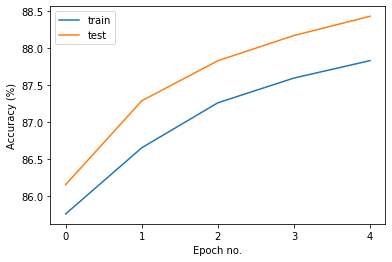

In [19]:

# c) Classify even-odd
from torchvision.transforms import Lambda

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            target_transform=Lambda(lambda y: 0 if y % 2 == 0 else 1)
                            )
test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           target_transform=Lambda(lambda y: 0 if y % 2 == 0 else 1))
input_dim = 28*28
output_dim = 2

model = LogisticRegressionModel(input_dim, output_dim)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)       
history = train(0.01)
history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
plt.gca().set_xticks(list(range(num_epochs)))

# Part 3: CNN

In [20]:
import torchvision
# import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [21]:
class CNNModel(nn.Module):
    def __init__(self, padding, avg_pool=False):
        super(CNNModel, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=padding)
        self.relu1 = nn.LeakyReLU() # Becaue we want to use leaky relu


        # Max/avg pool, depending on param
        self.pool1 = nn.MaxPool2d(kernel_size=2) if not avg_pool else nn.AvgPool2d(kernel_size=2) # Dynamic pooling based on param

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=padding)
        
        # Max/avg pool 2
        self.pool2 = nn.MaxPool2d(kernel_size=2) if not avg_pool else nn.AvgPool2d(kernel_size=2)
        self.relu2 = nn.LeakyReLU() # Becaue we want to use leaky relu

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(8 * 8 * 32 if padding == 2 else 5 * 5 * 32, 10) 

    def forward(self, x):

        # x
        # Convolution 1        
        out = self.cnn1(x)
        out = self.relu1(out)

        
        # Max/avg pool 1
        out = self.pool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max/avg pool 2 
        out = self.pool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

In [22]:
# The code we will use to create the models later
# a = CNNModel(2)
# b = CNNModel(2, avg_pool=True)
# c = CNNModel(0)


In [23]:

def train_with_batchsize(model, batch_size):    
    num_epochs = 3

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    def calc_accuracy(train=False): # add train param to calculate accuracy on both train and test
        # Calculate Accuracy         
        correct = 0
        total = 0
        
        d_loader = train_loader if train else test_loader
        # Iterate through test dataset
        for images, labels in d_loader:
            # Load images
            images = images.requires_grad_()

            # Forward pass only to get logits/output
            outputs = model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum()

        return 100 * correct / total

    def train(): # make into train function
        optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
        accuracy = {'train': [], 'test': []} # keep track of accuracies

        for epoch in range(num_epochs):    
            for i, (images, labels) in enumerate(train_loader): # One epoch = 600 iterations or (train_dataset / batch_size)
                # This will load batch_size amount of samples
                images = images.requires_grad_()

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels)

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()

            train_accuracy = calc_accuracy(train=True) # abstract accuracy function away
            test_accuracy = calc_accuracy() # abstract accuracy function away
            # Print Loss
            print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

            accuracy['train'].append(train_accuracy.item())
            accuracy['test'].append(test_accuracy.item())
            
        return pd.DataFrame(accuracy)
    
    return train()


Epoch: 0 Loss: 0.5598821043968201. Train Accuracy: 57.46200180053711, Test Accuracy: 56.40999984741211
Epoch: 1 Loss: 1.1848570108413696. Train Accuracy: 65.74800109863281, Test Accuracy: 64.12999725341797
Epoch: 2 Loss: 0.5139070153236389. Train Accuracy: 69.03199768066406, Test Accuracy: 66.0
Epoch: 0 Loss: 1.3896740674972534. Train Accuracy: 49.645999908447266, Test Accuracy: 48.5099983215332
Epoch: 1 Loss: 1.1491261720657349. Train Accuracy: 57.26599884033203, Test Accuracy: 55.75
Epoch: 2 Loss: 1.2209999561309814. Train Accuracy: 62.49399948120117, Test Accuracy: 60.2400016784668
Epoch: 0 Loss: 1.5154244899749756. Train Accuracy: 44.599998474121094, Test Accuracy: 44.61000061035156
Epoch: 1 Loss: 1.4460153579711914. Train Accuracy: 51.29199981689453, Test Accuracy: 50.7400016784668
Epoch: 2 Loss: 1.2851582765579224. Train Accuracy: 55.178001403808594, Test Accuracy: 53.58000183105469


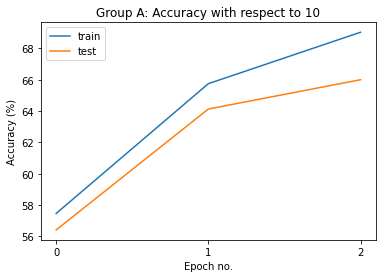

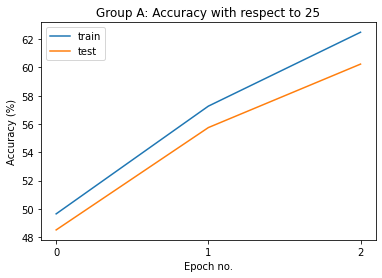

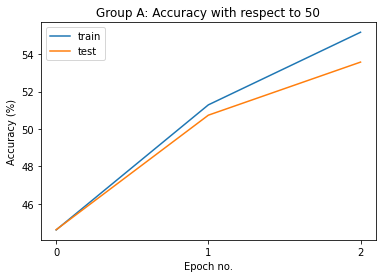

In [24]:
# Model a
batch_sizes = [10, 25, 50]

a_group = []
for sz in batch_sizes:
    model = CNNModel(2)    
    history = train_with_batchsize(model, sz)
    a_group.append(model)
    
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.title(f'Group A: Accuracy with respect to {sz}')
    plt.gca().set_xticks(list(range(0, 3)))


Epoch: 0 Loss: 1.103511095046997. Train Accuracy: 49.854000091552734, Test Accuracy: 49.77000045776367
Epoch: 1 Loss: 0.9285357594490051. Train Accuracy: 57.84199905395508, Test Accuracy: 56.04999923706055
Epoch: 2 Loss: 0.8265911340713501. Train Accuracy: 62.5620002746582, Test Accuracy: 60.15999984741211
Epoch: 0 Loss: 1.6047266721725464. Train Accuracy: 44.08399963378906, Test Accuracy: 43.959999084472656
Epoch: 1 Loss: 1.3166017532348633. Train Accuracy: 50.5260009765625, Test Accuracy: 50.08000183105469
Epoch: 2 Loss: 1.093837857246399. Train Accuracy: 55.529998779296875, Test Accuracy: 54.70000076293945
Epoch: 0 Loss: 1.6697132587432861. Train Accuracy: 37.790000915527344, Test Accuracy: 37.880001068115234
Epoch: 1 Loss: 1.5981236696243286. Train Accuracy: 47.40800094604492, Test Accuracy: 47.34000015258789
Epoch: 2 Loss: 1.5622243881225586. Train Accuracy: 50.19200134277344, Test Accuracy: 49.86000061035156


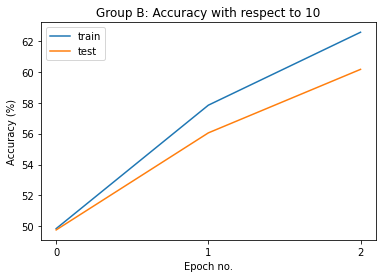

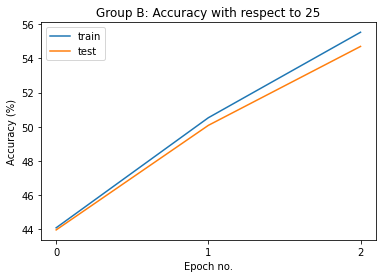

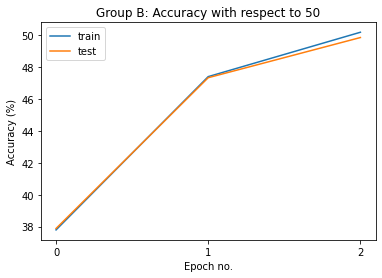

In [25]:
# Model b
batch_sizes = [10, 25, 50]

b_group = []
for sz in batch_sizes:
    model = CNNModel(2, avg_pool=True)
    history = train_with_batchsize(model, sz)
    
    b_group.append(model)
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.title(f'Group B: Accuracy with respect to {sz}')
    plt.gca().set_xticks(list(range(0, 3)))

Epoch: 0 Loss: 1.8451404571533203. Train Accuracy: 52.65999984741211, Test Accuracy: 51.45000076293945
Epoch: 1 Loss: 0.8900260925292969. Train Accuracy: 60.90999984741211, Test Accuracy: 59.220001220703125
Epoch: 2 Loss: 1.079210638999939. Train Accuracy: 65.4020004272461, Test Accuracy: 62.77000045776367
Epoch: 0 Loss: 1.249843716621399. Train Accuracy: 46.25400161743164, Test Accuracy: 45.880001068115234
Epoch: 1 Loss: 1.3644813299179077. Train Accuracy: 53.422000885009766, Test Accuracy: 52.29999923706055
Epoch: 2 Loss: 1.5670433044433594. Train Accuracy: 58.66600036621094, Test Accuracy: 57.7400016784668
Epoch: 0 Loss: 1.7798707485198975. Train Accuracy: 40.849998474121094, Test Accuracy: 40.560001373291016
Epoch: 1 Loss: 1.5465731620788574. Train Accuracy: 46.2859992980957, Test Accuracy: 45.79999923706055
Epoch: 2 Loss: 1.4308555126190186. Train Accuracy: 49.987998962402344, Test Accuracy: 49.540000915527344


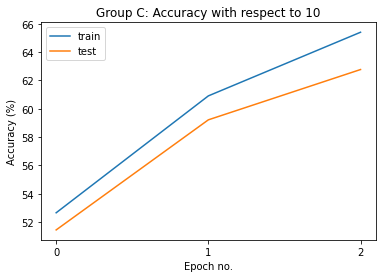

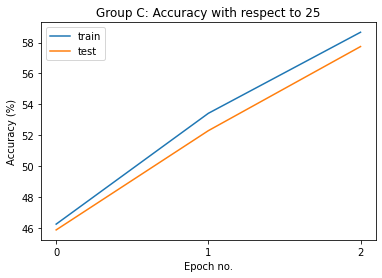

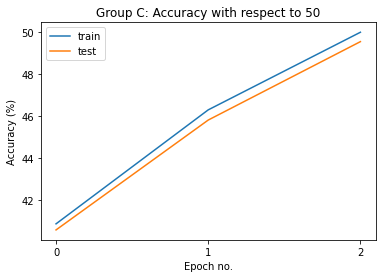

In [26]:
# Model c
batch_sizes = [10, 25, 50]

c_group = []
for sz in batch_sizes:
    model = CNNModel(0)
    history = train_with_batchsize(model, sz)
    
    c_group.append(model)
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.title(f'Group C: Accuracy with respect to {sz}')
    plt.gca().set_xticks(list(range(0, 3)))

## Comments on results

It's interesting to me that the very first model did the best; we can see that max pooling appears to work much better than average pooling for the CIFAR-10 dataset using a CNN. It also seemed that in general a smaller batch size performed better than a larger one: I think this is because we are able to update more often and descend the gradient faster. I think if we were to train for a thousand epochs or something like that this difference would become negligible. It's also impressive to me the performance of these models, as the last homework with nearest neighbors was only able to achieve around 30% accuracy.

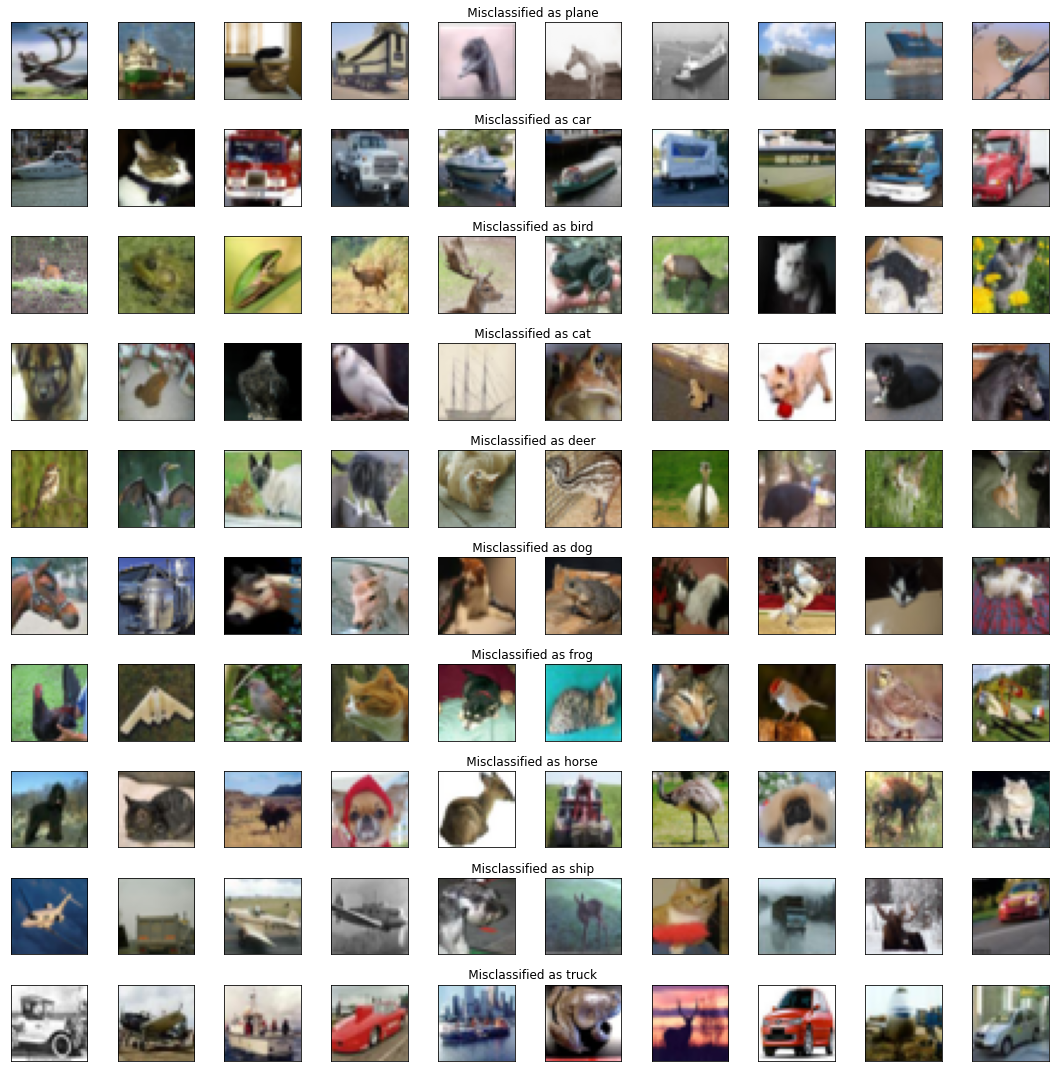

In [27]:


# b) Find 10 misclassified test samples for each output class


test_loader = torch.utils.data.DataLoader(testset, batch_size=10,
                                        shuffle=False, num_workers=2)

inv_normalize = transforms.Normalize(
    (-1, -1, -1),
    (2, 2, 2)
)


best_model = a_group[0]
misclassified = {k: [] for k in range(10)}
incorrect = []
i = 0
for images, labels in test_loader:

    outputs = best_model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)    
    for pred, act, image in zip(predicted, labels, images):
        if pred != act:
            misclassified[pred.item()].append(image) # save misclassified images

fig=plt.figure(figsize=(15, 15))

for clas in range(10):
    for i in range(1, 11):
        img = (inv_normalize(misclassified[clas][i])).numpy()
        img = np.dstack((img[0], img[1], img[2]))
        ax = fig.add_subplot(10, 10, clas * 10 + i)
        ax.set_xticks([])
        ax.set_yticks([])
        if i % 5 == 0 and i % 10 != 0:
            ax.set_title(f"                             Misclassified as {classes[clas]}")
        plt.imshow(img)        

plt.tight_layout()
plt.show()





## Speculation on misclassification

I don't think it's worth much to speculate as this would require deeper introspection into how the model works, but I found it interesting that many of the misclassified animal classes are also animals, while misclassified objects into the plane, ship, and truck classes also tend to be objects.

In [28]:
# c) Calculate total number of trainable parameters in all models

def calc_params(model):
    total_params = 0
    parameters = list(model.parameters())

    # All the odd indices contains biases, while all even indices are weights
    
    # Convolution 1: 16 Kernels
    # Convolution 1 Bias: 16 Kernels
    # Convolution 2: 32 Kernels with depth = 16
    # Convolution 2 Bias: 32 Kernels with depth = 16
    # Fully Connected Layer 1
    # Fully Connected Layer Bias
    num_weights = 0
    num_biases = 0
    
    for (i, param) in enumerate(parameters):
        layer_params = 1
        for dim in param.shape:
            layer_params *= dim
        
        if i % 2 == 0:
            num_weights += layer_params
        else:
            num_biases += layer_params
            
        total_params += layer_params
    
    return f'\nNumber of weights: {num_weights}, Number of biases: {num_biases}, Total number of parameters: {total_params}\n'

    

print(f'Model A: {calc_params(a_group[0])}')
print(f'Model B: {calc_params(b_group[0])}')
print(f'Model C: {calc_params(c_group[0])}')

Model A: 
Number of weights: 34480, Number of biases: 58, Total number of parameters: 34538

Model B: 
Number of weights: 34480, Number of biases: 58, Total number of parameters: 34538

Model C: 
Number of weights: 22000, Number of biases: 58, Total number of parameters: 22058

